<a href="https://colab.research.google.com/github/2303A52445/Explainable-AI-Lab/blob/main/LAB_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2303A52445 Batch 39

Accuracy: 1.0


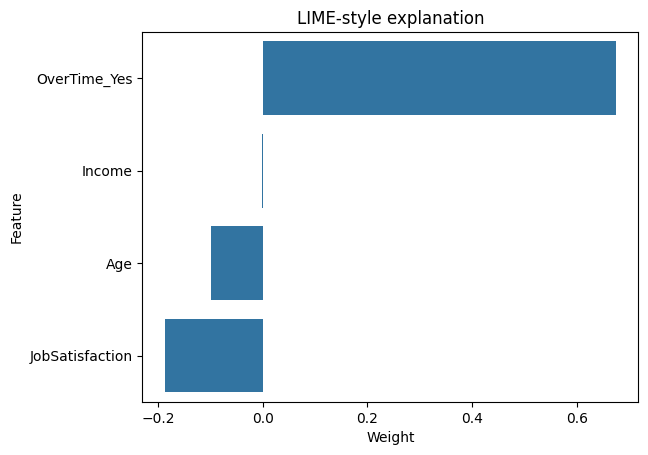

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

# 1. Create small synthetic HR dataset
np.random.seed(42)
n = 500
df = pd.DataFrame({
    "Age": np.random.randint(20, 60, n),
    "Income": np.random.randint(3000, 20000, n),
    "JobSatisfaction": np.random.randint(1, 5, n),
    "OverTime": np.random.choice(["Yes", "No"], n, p=[0.3, 0.7])
})
df["Attrition"] = np.where((df["OverTime"]=="Yes") & (df["JobSatisfaction"]<=2), "Yes","No")

# FIXED LINE
X, y = df.drop(columns=["Attrition"]), df["Attrition"]

num, cat = X.select_dtypes(exclude="object").columns, X.select_dtypes("object").columns

#2. Preprocess + Random Forest
prep = ColumnTransformer([("num", StandardScaler(), num),
                          ("cat", OneHotEncoder(drop="first"), cat)])
model = Pipeline([("prep", prep), ("rf", RandomForestClassifier(n_estimators=200, random_state=42))])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
model.fit(X_train,y_train)
print("Accuracy:", model.score(X_test,y_test))

#  3. Simple LIME-style explanation
def lime_explain(x_row, model, feature_names, num_samples=300):
    perturbed = pd.DataFrame([x_row]*num_samples)
    for c in perturbed.columns:
        if c in num: perturbed[c] += np.random.normal(0,1,num_samples)
        else: perturbed[c] = np.random.choice(X[c].unique(), num_samples)
    probs = model.predict_proba(perturbed)[:,1]
    enc = model.named_steps["prep"].transform(perturbed)
    ridge = Ridge(alpha=1.0).fit(enc, probs)
    return pd.DataFrame({"Feature": feature_names,"Weight":ridge.coef_})

#  4. Pick a random employee and plot
feat_names = num.tolist() + list(model.named_steps["prep"].named_transformers_["cat"].get_feature_names_out(cat))
i = np.random.randint(len(X_test))
exp = lime_explain(X_test.iloc[i], model, feat_names)

sns.barplot(x="Weight", y="Feature", data=exp.sort_values("Weight",ascending=False).head(10))
plt.title("LIME-style explanation")
plt.show()


Gradient Boosting Accuracy: 1.0


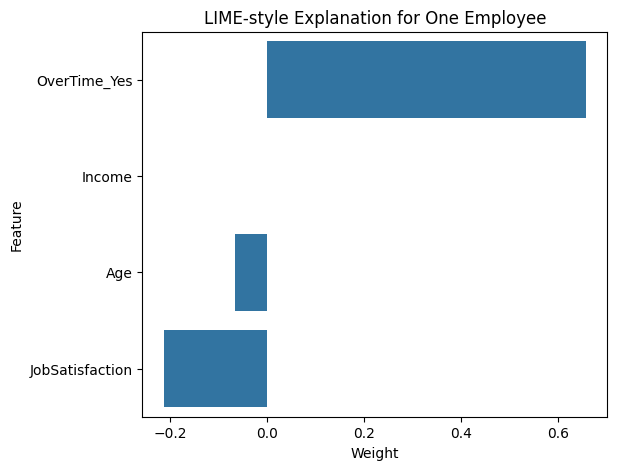

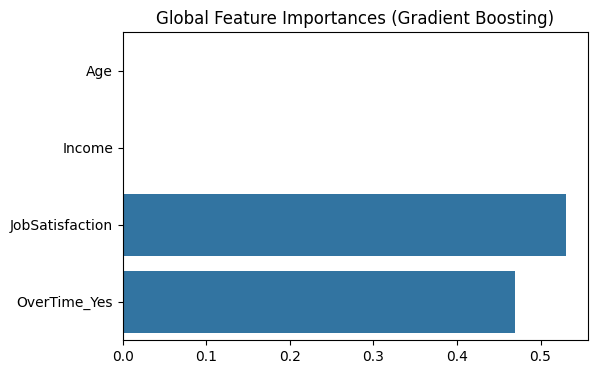

In [ ]:
# HR Attrition Prediction with Gradient Boosting + LIME-style Explanation
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Ridge

# ---------------------------
# 1. Create / Load dataset
# ---------------------------
np.random.seed(42)
n = 500
df = pd.DataFrame({
    "Age": np.random.randint(20, 60, n),
    "Income": np.random.randint(3000, 20000, n),
    "JobSatisfaction": np.random.randint(1, 5, n),
    "OverTime": np.random.choice(["Yes", "No"], n, p=[0.3, 0.7])
})
df["Attrition"] = np.where((df["OverTime"]=="Yes") & (df["JobSatisfaction"]<=2), "Yes","No")

X, y = df.drop(columns=["Attrition"]), df["Attrition"]

num = X.select_dtypes(exclude="object").columns
cat = X.select_dtypes("object").columns

# ---------------------------
# 2. Preprocessing + Model
# ---------------------------
prep = ColumnTransformer([
    ("num", StandardScaler(), num),
    ("cat", OneHotEncoder(drop="first"), cat)
])

model = Pipeline([
    ("prep", prep),
    ("gb", GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

print("Gradient Boosting Accuracy:", model.score(X_test, y_test))

# ---------------------------
# 3. LIME-style Explanation
# ---------------------------
def lime_explain(x_row, model, feature_names, num_samples=500):
    # Create perturbed dataset
    perturbed = pd.DataFrame([x_row] * num_samples)
    for c in perturbed.columns:
        if c in num:
            perturbed[c] += np.random.normal(0, 1, num_samples)
        else:
            perturbed[c] = np.random.choice(X[c].unique(), num_samples)

    # Model predictions
    probs = model.predict_proba(perturbed)[:, 1]

    # Encoded features
    enc = model.named_steps["prep"].transform(perturbed)

    # Local surrogate (Ridge regression)
    ridge = Ridge(alpha=1.0).fit(enc, probs)
    return pd.DataFrame({"Feature": feature_names, "Weight": ridge.coef_})

# ---------------------------
# 4. Visualizations
# ---------------------------
# Feature names after encoding
feat_names = num.tolist() + list(model.named_steps["prep"]
                                 .named_transformers_["cat"]
                                 .get_feature_names_out(cat))

# Pick one employee
i = np.random.randint(len(X_test))
exp = lime_explain(X_test.iloc[i], model, feat_names)

# Plot local explanation
plt.figure(figsize=(6, 5))
sns.barplot(x="Weight", y="Feature",
            data=exp.sort_values("Weight", ascending=False).head(10))
plt.title("LIME-style Explanation for One Employee")
plt.show()

# Global feature importances
plt.figure(figsize=(6, 4))
imp = model.named_steps["gb"].feature_importances_
sns.barplot(x=imp, y=feat_names)
plt.title("Global Feature Importances (Gradient Boosting)")
plt.show()
